# Simple classification with Convolutionnal Neural Networks

## Goals

- Discover the famous MNIST Handwritten numbers dataset
- Implement and use de simple DNN classifier


### Load libraries

In [2]:
import sys
import os
import itertools

import math
import numpy as np
import matplotlib.pyplot as plt


from importlib import reload

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix

### Load the data

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1,28,28,1)
x_test  = x_test.reshape(-1,28,28,1)

print("x_train : ",x_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",x_test.shape)
print("y_test  : ",y_test.shape)

x_train :  (60000, 28, 28, 1)
y_train :  (60000,)
x_test  :  (10000, 28, 28, 1)
y_test  :  (10000,)


In [9]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))

Before normalization : Min=0, max=255
After normalization  : Min=0.0, max=1.0


### Visualize the data

In [10]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as='auto'):
    """
    From FIDLE
    Show some images in a grid, with legends 
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    #save_fig(save_as)
    plt.show()



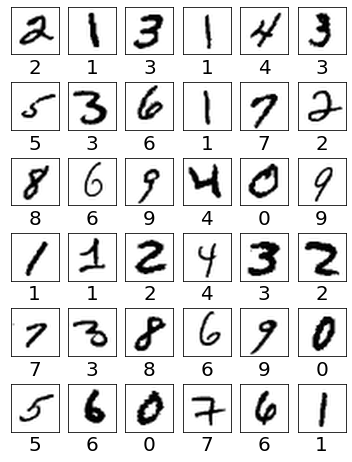

In [11]:
plot_images(x_train, y_train, range(5,41), columns=6)

### Create the CNN 

In [12]:
model = keras.models.Sequential()

model.add( keras.layers.Input((28,28,1)) )

model.add( keras.layers.Conv2D(8, (3,3),  activation='relu') ) # 8 3x3 filters hence reLU
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Conv2D(16, (3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(100, activation='relu'))
model.add( keras.layers.Dropout(0.5))

model.add( keras.layers.Dense(10, activation='softmax'))

## That's it !!!

### Compile the network

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)              

Note that for the DNN network work, the number of parameters was 89,610

### Train the model

In [15]:
batch_size  = 256 
epochs      =  16

history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = (x_test, y_test))

2021-12-14 14:09:58.156591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/16
235/235 [==============================] - 15s 63ms/step - loss: 1.3448 - accuracy: 0.5470 - val_loss: 0.1915 - val_accuracy: 0.9474
Epoch 2/16
235/235 [==============================] - 17s 74ms/step - loss: 0.3309 - accuracy: 0.9007 - val_loss: 0.1118 - val_accuracy: 0.9679
Epoch 3/16
235/235 [==============================] - 18s 77ms/step - loss: 0.2343 - accuracy: 0.9285 - val_loss: 0.0846 - val_accuracy: 0.9744
Epoch 4/16
235/235 [==============================] - 18s 79ms/step - loss: 0.1930 - accuracy: 0.9413 - val_loss: 0.0705 - val_accuracy: 0.9785
Epoch 5/16
235/235 [==============================] - 20s 85ms/step - loss: 0.1730 - accuracy: 0.9477 - val_loss: 0.0602 - val_accuracy: 0.9808
Epoch 6/16
235/235 [==============================] - 19s 79ms/step - loss: 0.1477 - accuracy: 0.9549 - val_loss: 0.0550 - val_accuracy: 0.9825
Epoch 7/16
235/235 [==============================] - 25s 107ms/step - loss: 0.1399 - accuracy: 0.9576 - val_loss: 0.0511 - val_accuracy

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss     :', score[0])
print('Test accuracy :', score[1])

Test loss     : 0.03435024619102478
Test accuracy : 0.9883000254631042


Note that for the DNN network, the accuracy war about 97.87%

### Plot history at each epoch

In [17]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        if save_as=='auto':
            figname='auto'
        else:
            figname=f'{save_as}_{fig_id}'
            fig_id+=1
        #save_fig(figname)
        plt.show()


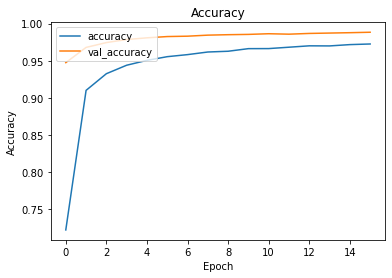

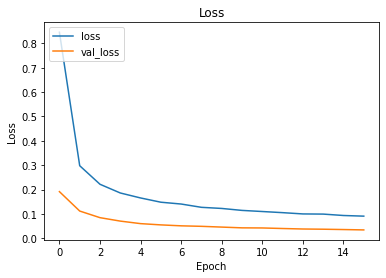

In [18]:
plot_history(history, figsize=(6,4))

In [19]:
#y_sigmoid = model.predict(x_test)
#y_pred    = np.argmax(y_sigmoid, axis=-1)

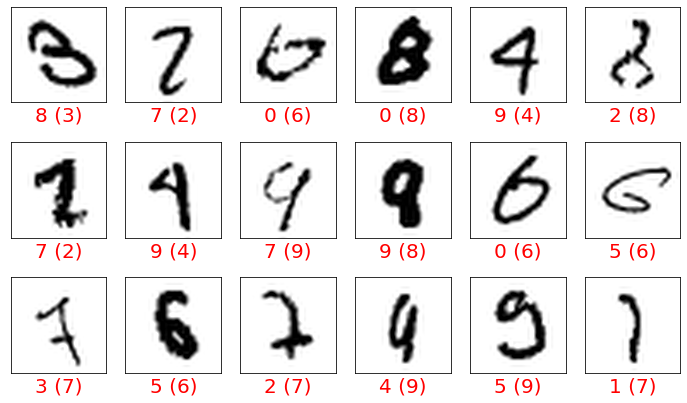

In [20]:
#errors=[ i for i in range(len(x_test)) if y_pred[i]!=y_test[i] ]
#errors=errors[:min(24,len(errors))]
#plot_images(x_test, y_test, errors[:18], columns=6, x_size=2, y_size=2, y_pred=y_pred)

### Plot the confusion matrix

In [21]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #save_fig(save_as)
    plt.show()

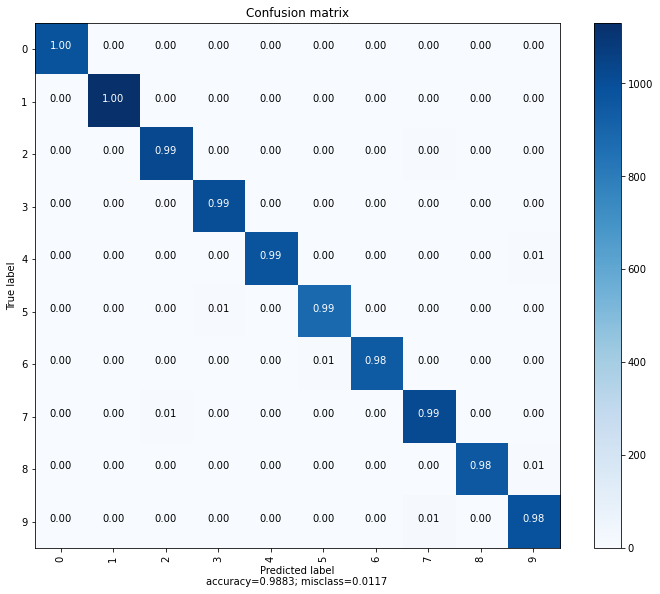

In [22]:
plot_confusion_matrix(y_test,y_pred,range(10), normalize=True)